In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


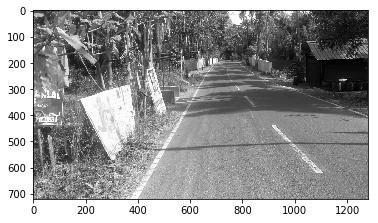

In [3]:
#reading in an image
image = mpimg.imread('test_images/p1.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
gray=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#plt.imshow(image)  

plt.imshow(gray, cmap='gray') 


In [4]:
import os
os.listdir("test_images/")

['Image_1553484991377.jpg',
 'Image_1553484994378.jpg',
 'Image_1553484996029.jpg',
 'Image_1553484998921.jpg',
 'Image_1553485000618.jpg',
 'Image_1553485004805.jpg',
 'Image_1553485006597.jpg',
 'Image_1553485008432.jpg',
 'Image_1553485012526.jpg',
 'Image_1553485014377.jpg',
 'Image_1553485016127.jpg',
 'Image_1553485017812.jpg',
 'p1.jpg']

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    blur = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    mpimg.imsave(outDirectory + "/" + "blur", blur)
    
    return blur
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    canny = cv2.Canny(img, low_threshold, high_threshold)
    mpimg.imsave(outDirectory + "/" + "canny", canny)
    return canny
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)  
    
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    mpimg.imsave(outDirectory + "/" + "maskedimage", masked_image)
    return masked_image
import math

def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1,a2, b1,b2):
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

def movingAverage(avg, new_sample, N=20):
    if (avg == 0):
        return new_sample
    avg -= avg / N;
    avg += new_sample / N;
    return avg;
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    weight = cv2.addWeighted(initial_img, α, img, β, λ)
    mpimg.imsave(outDirectory + "/" + "weight", weight)
    return weight

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # state variables to keep track of most dominant segment
    largestLeftLineSize = 0
    largestRightLineSize = 0
    largestLeftLine = (0,0,0,0)
    largestRightLine = (0,0,0,0)
    global avgLeft
    global avgRight
    if lines is None:
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        mpimg.imsave(outDirectory + "/" + "lt1", img)
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        mpimg.imsave(outDirectory + "/" + "lt2", img)
        return
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            size = math.hypot(x2 - x1, y2 - y1)
            slope = ((y2-y1)/(x2-x1))
            # Filter slope based on incline and
            # find the most dominent segment based on length
            if (slope > 0.5): #right
                if (size > largestRightLineSize):
                    largestRightLine = (x1, y1, x2, y2)                    
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                mpimg.imsave(outDirectory + "/" + "l", img)
            elif (slope < -0.5): #left
                if (size > largestLeftLineSize):
                    largestLeftLine = (x1, y1, x2, y2)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                mpimg.imsave(outDirectory + "/" + "r", img)

    # Define an imaginary horizontal line in the center of the screen
    # and at the bottom of the image, to extrapolate determined segment
    imgHeight, imgWidth = (img.shape[0], img.shape[1])
    upLinePoint1 = np.array( [0, int(imgHeight - (imgHeight/3))] )
    upLinePoint2 = np.array( [int(imgWidth), int(imgHeight - (imgHeight/3))] )
    downLinePoint1 = np.array( [0, int(imgHeight)] )
    downLinePoint2 = np.array( [int(imgWidth), int(imgHeight)] )
    
    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p3 = np.array( [largestLeftLine[0], largestLeftLine[1]] )
    p4 = np.array( [largestLeftLine[2], largestLeftLine[3]] )
    upLeftPoint = seg_intersect(upLinePoint1,upLinePoint2, p3,p4)
    downLeftPoint = seg_intersect(downLinePoint1,downLinePoint2, p3,p4)
    if (math.isnan(upLeftPoint[0]) or math.isnan(downLeftPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        mpimg.imsave(outDirectory + "/" + "ls1", img)
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        mpimg.imsave(outDirectory + "/" + "ls2", img)
        return
    cv2.line(img, (int(upLeftPoint[0]), int(upLeftPoint[1])), (int(downLeftPoint[0]), int(downLeftPoint[1])), [0, 0, 255], 8) #draw left line
    mpimg.imsave(outDirectory + "/" + "lsf", img)
    # Calculate the average position of detected left lane over multiple video frames and draw
    
    avgx1, avgy1, avgx2, avgy2 = avgLeft
    avgLeft = (movingAverage(avgx1, upLeftPoint[0]), movingAverage(avgy1, upLeftPoint[1]), movingAverage(avgx2, downLeftPoint[0]), movingAverage(avgy2, downLeftPoint[1]))
    avgx1, avgy1, avgx2, avgy2 = avgLeft
    cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
    
    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p5 = np.array( [largestRightLine[0], largestRightLine[1]] )
    p6 = np.array( [largestRightLine[2], largestRightLine[3]] )
    upRightPoint = seg_intersect(upLinePoint1,upLinePoint2, p5,p6)
    downRightPoint = seg_intersect(downLinePoint1,downLinePoint2, p5,p6)
    if (math.isnan(upRightPoint[0]) or math.isnan(downRightPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        mpimg.imsave(outDirectory + "/" + "rs1", img)
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        mpimg.imsave(outDirectory + "/" + "rs2", img)
        return
    cv2.line(img, (int(upRightPoint[0]), int(upRightPoint[1])), (int(downRightPoint[0]), int(downRightPoint[1])), [0, 0, 255], 8) #draw left line
    mpimg.imsave(outDirectory + "/" + "rsf", img)
    # Calculate the average position of detected right lane over multiple video frames and draw
    
    avgx1, avgy1, avgx2, avgy2 = avgRight
    avgRight = (movingAverage(avgx1, upRightPoint[0]), movingAverage(avgy1, upRightPoint[1]), movingAverage(avgx2, downRightPoint[0]), movingAverage(avgy2, downRightPoint[1]))
    avgx1, avgy1, avgx2, avgy2 = avgRight
    cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
     
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)
    
    return line_img

In [ ]:
# NOTE: The output you return should be a color image (3 channel) for processing video below
def process_image(image):

    # grayscale conversion before processing causes more harm than good
    # because sometimes the lane and road have same amount of luminance
    # grayscaleImage = grayscale(image)

    # Blur to avoid edges from noise
    blurredImage = gaussian_blur(image, 11)
    
    # Detect edges using canny
    # high to low threshold factor of 3
    # it is necessary to keep a linient threshold at the lower end
    # to continue to detect faded lane markings
    edgesImage = canny(blurredImage, 40, 50)
    
    # mark out the trapezium region of interest
    # dont' be too agressive as the car may drift laterally
    # while driving, hence ample space is still left on both sides.
    height = image.shape[0]
    width = image.shape[1]
    vertices = np.array( [[
                [3*width/4, 3*height/5],
                [width/4, 3*height/5],
                [40, height],
                [width - 40, height]
            ]], dtype=np.int32 )
    
    # mask the canny output with trapezium region of interest
    regionInterestImage = region_of_interest(edgesImage, vertices)
    
    # parameters tuned using this method:
    # threshold 30 by modifying it and seeing where slightly curved 
    # lane markings are barely detected
    # min line length 20 by modifying and seeing where broken short
    # lane markings are barely detected
    # max line gap as 100 to allow plenty of room for the algo to 
    # connect spaced out lane markings
    lineMarkedImage = hough_lines(regionInterestImage, 1, np.pi/180, 40, 30, 200)
    mpimg.imsave(outDirectory + "/" + "linemarked", lineMarkedImage)
    # Test detected edges by uncommenting this
    # return cv2.cvtColor(regionInterestImage, cv2.COLOR_GRAY2RGB)

    # draw output on top of original
    wgh_img=weighted_img(lineMarkedImage, image)
    mpimg.imsave(outDirectory + "/" + "weighted", wgh_img)
    return 


# debug on images
inDirectory = "test_images"
outDirectory = inDirectory + "_out"
if not os.path.exists(outDirectory):
    os.makedirs(outDirectory)
imageNames = os.listdir(inDirectory + "/")
for imageName in imageNames:
    avgLeft = (0, 0, 0, 0)
    avgRight = (0, 0, 0, 0)
    image = mpimg.imread(inDirectory + "/" + imageName)
    out = process_image(image)
    mpimg.imsave(outDirectory + "/" + imageName, out)
    print("Processed " + outDirectory + "/" + imageName)
print("Processing complete.")

In [ ]:
# reset global state of average values
avgLeft = (0, 0, 0, 0)
avgRight = (0, 0, 0, 0)

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
# reset global state of average values
avgLeft = (0, 0, 0, 0)
avgRight = (0, 0, 0, 0)

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')

yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))